# A set of blends to showcase multiresolution deblending

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

## Load and Display Data

We first load the HSC and HST images, swapping the byte order if necessary because a bug in astropy does not respect the local endianness.

In [50]:
coords = ((150.2311511, 2.0725000),
(150.23575, 2.0736144),
(150.2407120, 2.06514),
(150.2537000, 2.0480000),
(150.3054000, 2.0823254),
(150.3305180, 2.0707583))

psf_hst = fits.open('./data/PSF_HST.fits')[0].data
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet.PSF(psf_hst)

coord = coords[0]
# Load the sample images
obs_hdu = fits.open(f'data/hsc_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)

obs_hdu = fits.open(f'data/hst_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')
data_hst = obs_hdu[0].data.byteswap().newbyteorder()[None,:,:]
wcs_hst = WCS(obs_hdu[0].header)

psf_hsc = fits.open(f'data/psf_hsc_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')[0].data
psf_hsc = scarlet.PSF(psf_hsc)

channels_hst = ['F814w']
channels_hsc = ['g','r','i','z','y']

In [51]:
import sep

class Data():
    
    def __init__(self, images, wcss, psfs, channels):
        self.images = images
        self.wcs = wcss
        self.psfs = psfs.image
        self.channels = channels

def interpolate(data_lr, data_hr):
    #Interpolate low resolution data to high resolution
    coord_lr0 = (np.arange(data_lr.images.shape[1]), np.arange(data_lr.images.shape[1]))
    coord_hr = (np.arange(data_hr.images.shape[1]), np.arange(data_hr.images.shape[1]))
    coord_lr = scarlet.resampling.convert_coordinates(coord_lr0, data_lr.wcs, data_hr.wcs)
    
    interp = []
    for image in data_lr.images:
        interp.append(scarlet.interpolation.sinc_interp(image[None, :,:], coord_hr, coord_lr, angle=None)[0].T)
    return np.array(interp)
        
def makeCatalog_multi(data_lr, data_hr, lvl = 3, wave = True):
    #Create observations for each image
    #Interpolate low resolution to high resolution
    interp = interpolate(data_lr, data_hr)
    #Normalisation of the interpolate low res images
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    #Normalisation of the high res data
    hr_images = data_hr.images/np.sum(data_hr.images, axis = (1,2))[:,None, None]
    #Detection image as the sum over all images
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    detect_image *= np.sum(data_hr.images)
    plt.imshow(np.log10(data_hst)[0])
    plt.show()
    if np.size(detect_image.shape) == 3:
        if wave:
            #Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0)).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            #Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            detect = detect_image
    

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    bg_rms = []
    for data in datas:
        img = data.images
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
    bg_rms = np.array(bg_rms)
    print(data_lr.images.shape)
    weights_hr = np.ones_like(data_hr.images) / (bg_rms[1]**2)[:, np.newaxis, np.newaxis]
    weights_lr = np.ones_like(data_lr.images) / (bg_rms[0]**2)[:, None, None]
    return catalog, weights_hr, weights_lr, detect_image


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


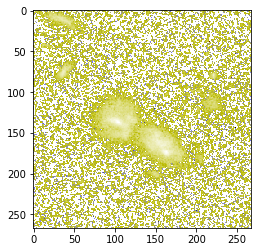

(5, 54, 54)


In [52]:
data_hr =  Data(data_hst, wcs_hst, psf_hst, channels_hst)
data_lr =  Data(data_hsc, wcs_hsc, psf_hsc, channels_hsc)
datas = [data_lr, data_hr]

wave = 1
lvl = 3
catalog_multi, w_hst, w_hsc, detect_multi = makeCatalog_multi(data_lr, data_hr, lvl, wave)

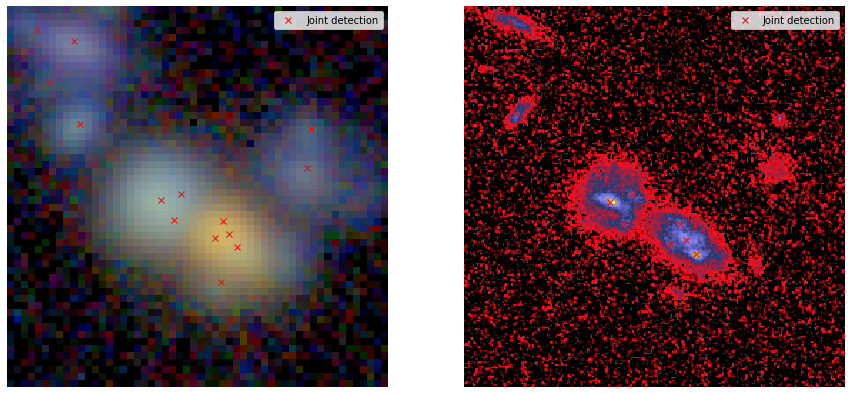

In [53]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=0, stretch=1, Q=10)
hst_norm = AsinhMapping(minimum=0, stretch=100, Q=1)

# Get the source coordinates from the HST catalog
xm,ym = catalog_multi['x'], catalog_multi['y']
# Convert the HST coordinates to the HSC WCS
ram, decm = wcs_hst.wcs_pix2world(ym,xm,0)

Ym,Xm, l = wcs_hsc.wcs_world2pix(ram, decm, 0, 0)
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(data_hsc, norm=hsc_norm)
# Apply Asinh to the HST data
hst_img = scarlet.display.img_to_rgb(data_hst, norm=hst_norm)

plt.figure(figsize=(15,30))
plt.subplot(121)
plt.imshow(img_rgb)
plt.axis('off')
plt.plot(Xm,Ym, 'xr', label = 'Joint detection')
plt.legend()

plt.subplot(122)
plt.imshow(hst_img[:,:,0])
plt.axis('off')
plt.plot(xm,ym, 'xr', label = 'Joint detection')
plt.legend()
plt.show()

In [54]:
#Automated frame definition
# define two observation packages and match to frame
multi_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights=w_hst)
multi_hsc = scarlet.Observation(data_hsc, wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc, weights=w_hsc)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [multi_hsc, multi_hst]
frame = scarlet.Frame.from_observations(obs, coverage = 'intersection')
multi_hsc, multi_hst = obs

detect_multi *= np.sum(data_hst)/np.sum(detect_multi)
obs_detect = scarlet.Observation(detect_multi[None,:,:], wcs=wcs_hst, psfs=psf_hst, channels=channels_hst)
obs_detects = [multi_hsc, obs_detect]
frame_detect = scarlet.Frame.from_observations(obs_detects, coverage = 'intersection')

In [55]:
#Detection with multiple observations
multi_sources = [
    scarlet.ExtendedSource(frame_detect, (ram[i], decm[i]), obs_detects, 
                           symmetric=False, 
                           monotonic=True, 
                           obs_idx=1)
    for i in range(ram.size)
]

blend_multi = scarlet.Blend(multi_sources, obs)

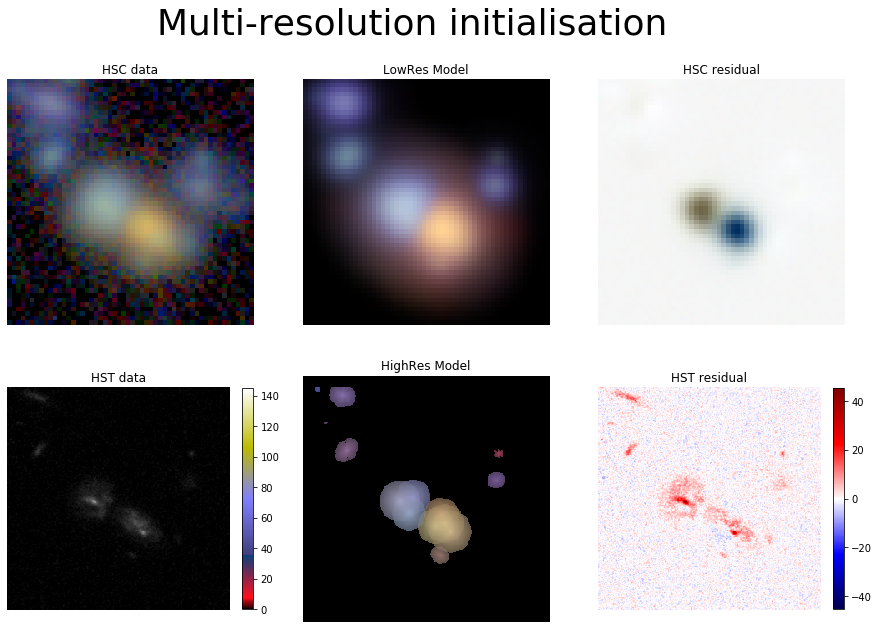

In [56]:
# Load the model and calculate the residual
model_multi = blend_multi.get_model()

model_lr = multi_hsc.render(model_multi)
init_rgb = scarlet.display.img_to_rgb(model_multi, norm=hsc_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr)

# Get the HR residual
residual_hr = (data_hst - multi_hst.render(model_multi))[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.suptitle('Multi-resolution initialisation', fontsize=36)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.axis('off')
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.axis('off')
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

CPU times: user 39min 21s, sys: 8min 33s, total: 47min 55s
Wall time: 3h 16min 13s
scarlet ran for 132 iterations to logL = -145022.84470710024


Text(0, 0.5, 'log-Likelihood')

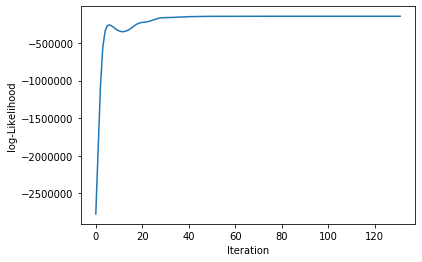

In [57]:
%time blend_multi.fit(150, e_rel = 1.e-6)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multi.loss), -blend_multi.loss[-1]))
plt.plot(-np.array(blend_multi.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

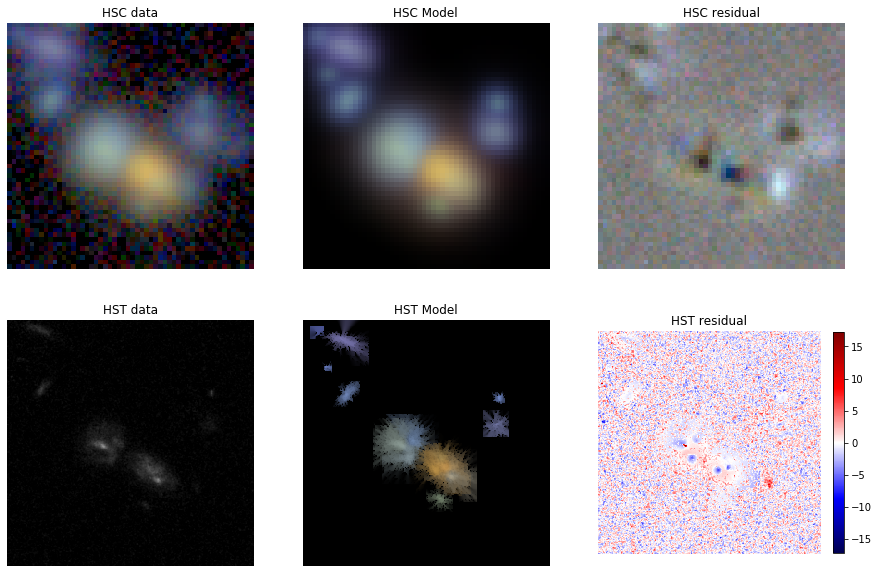

In [58]:
model_multi = blend_multi.get_model()
model_hr = multi_hst.render(model_multi)
model_lr = multi_hsc.render(model_multi)

rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=hsc_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:])

# Get the HR residual
residual_hr = (data_hst - model_hr)[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.axis('off')
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.axis('off')
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.axis('off')
plt.title('HST data')
plt.show()